In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
import librosa
import os
from IPython.display import Audio
import IPython.display as ipd
from playsound import playsound
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch, gc
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The acceleration is on: ", device)
stringLabels = ["SAD", "ANG", "NEU", "HAP", "FEA", "DIS"]
labelToIndex = {stringLabels[i]: i for i in range(len(stringLabels))}
files = np.array([])
labels = np.array([])
maxLen = 110361
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        # Reading the wav file
        if filename.endswith('.wav'):
            # Read the wav file (mono)
            files = np.append(files, os.path.join(dirname, filename))
            labels = np.append(labels, filename.split("_")[2])
def playAudio(path):
    playsound(path)

def getSamplingFrequency(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    return frameRate

def getAudioSignal(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    # Find the time of the audio file
    time = np.linspace(0, len(signal) / frameRate, num=len(signal))
    return signal, time


def calculateZeroCrossingRate(audioPath, frameSize, hopSize):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.zero_crossing_rate( y= audio, frame_length= frameSize, hop_length= hopSize)[0]) # We can make center=True to get more accurate results

def calculateEnergy(audioPath, frameSize, hopSize):
    """
    audioPath: The path of the audio file
    frameSize: The number of samples in each frame
    hopSize: The number of samples between successive frames
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.rms(y = audio, frame_length= frameSize, hop_length= hopSize)[0] ** 2) # We can make center=True to get more accurate results

def calculateMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    """"
    n_fft: The number of points in the FFT, which determines the frequency resolution of the spectrogram
    hopSize: The number of samples between successive frames
    n_mels: The number of mel frequency bands to generate in the spectrogram or the number of filters in the filterbank
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    # Normalize between 0 and 1
    if mel_spec_db.max() - mel_spec_db.min() != 0:
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / ((mel_spec_db.max() - mel_spec_db.min()) + 1e-6) # eps for numerical stability
    else:
        mel_spec_db = mel_spec_db - mel_spec_db.min()
    return mel_spec_db

def addNoise(y, sr):
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    return y_noise

def changeSpeed(y, sr):
    speed_change = np.random.uniform(low=0.9, high=1.1)
    return librosa.effects.time_stretch(y, rate = speed_change)

def timeShift(y, sr):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(y, shift_range)

def pitchShift(y, sr):
    pitch_change = int(np.random.randint(low=-3, high = 3))
    return librosa.effects.pitch_shift(y, sr = sr, n_steps=pitch_change)

def volumeScale(y, sr):
    volume_change = np.random.uniform(low=0.5, high = 1.5)
    return y * volume_change

def augmentData(data, label, savePath, noise, time_shift, change_speed, pitch_shift, volume_scale):
    augmentedData = []
    augmentedLabel = []
    flag = 0
    if not os.path.exists(savePath):
        os.makedirs(savePath)
        flag = 1
        
    for i in range(len(data)):
        fileName = data[i][8:23]
        
        if not flag:
            # Appending all of them to the augmentedData
            augmentedData.append(data[i])
            augmentedLabel.append(label[i])
            if noise:
                augmentedData.append(savePath+ "/" + str(fileName)+"_noised.wav")
                augmentedLabel.append(label[i])
            if change_speed:
                augmentedData.append(savePath+ "/" + str(fileName)+"_changeSpeed.wav")
                augmentedLabel.append(label[i])
            if time_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_timeShift.wav")
                augmentedLabel.append(label[i])
            if pitch_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_pitchShift.wav")
                augmentedLabel.append(label[i])
            if volume_scale:
                augmentedData.append(savePath+ "/" + str(fileName)+"_volumeScale.wav")
                augmentedLabel.append(label[i])
            continue
        
        augmentedData.append(data[i])
        augmentedLabel.append(label[i])

        audio, sr = librosa.load(data[i], sr=None)
        if noise:
            noisedAudio = addNoise(audio, sr)
            if( maxLen > len(noisedAudio) ):
                noisedAudio = np.pad(noisedAudio, (0, maxLen - len(noisedAudio)), 'constant')
            noisedAudio = noisedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_noised.wav", noisedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_noised.wav")
            augmentedLabel.append(label[i])
        if change_speed:
            changeSpeedAudio = changeSpeed(audio, sr)
            if( maxLen > len(changeSpeedAudio) ):
                changeSpeedAudio = np.pad(changeSpeedAudio, (0, maxLen - len(changeSpeedAudio)), 'constant')
            changeSpeedAudio = changeSpeedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_changeSpeed.wav", changeSpeedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_changeSpeed.wav")
            augmentedLabel.append(label[i])
        if time_shift:
            timeShiftAudio = timeShift(audio, sr)
            if( maxLen > len(timeShiftAudio) ):
                timeShiftAudio = np.pad(timeShiftAudio, (0, maxLen - len(timeShiftAudio)), 'constant')
            timeShiftAudio = timeShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_timeShift.wav", timeShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_timeShift.wav")
            augmentedLabel.append(label[i])
        if pitch_shift:
            pitchShiftAudio = pitchShift(audio, sr)
            if( maxLen > len(pitchShiftAudio) ):
                pitchShiftAudio = np.pad(pitchShiftAudio, (0, maxLen - len(pitchShiftAudio)), 'constant')
            pitchShiftAudio = pitchShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_pitchShift.wav", pitchShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_pitchShift.wav")
            augmentedLabel.append(label[i])
        if volume_scale:
            volumeScaleAudio = volumeScale(audio, sr)
            if( maxLen > len(volumeScaleAudio) ):
                volumeScaleAudio = np.pad(volumeScaleAudio, (0, maxLen - len(volumeScaleAudio)), 'constant')
            volumeScaleAudio = volumeScaleAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_volumeScale.wav", volumeScaleAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_volumeScale.wav")
            augmentedLabel.append(label[i])
    return augmentedData, augmentedLabel

def plotMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hopSize, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel spectrogram')
    plt.show()

def plotSpectrogram(audioPath, time):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    plt.figure(figsize=(15, 5))
    plt.specgram(audio, Fs=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()
    
def plotSignal(signal, time):
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.show()

def plotHistogram(data, dataTitle):
    plt.figure(figsize=(15, 5))
    plt.hist(data, bins=15)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Histogram of the ' + dataTitle)
    plt.show()

def extractFeatures(data, labels, n_fft, hopSize, n_mels):
    output = np.empty((len(data), 4), dtype=np.ndarray)
    
    for i, audioFile in enumerate(data):
        # Calculate the zero crossing rate
        zeroCrossingRate = calculateZeroCrossingRate(audioFile, n_fft, hopSize)
        # Calculate the energy
        energy = calculateEnergy(audioFile, n_fft, hopSize)
        # Calculate the Mel Spectrogram
        melSpectrogram = calculateMelSpectogram(audioFile, n_fft, hopSize, n_mels)
        # Append the features to the output array
        output[i][0] = zeroCrossingRate
        output[i][1] = energy
        output[i][2] = melSpectrogram
        output[i][3] = labels[i]
        output[i][0] = output[i][0].reshape(1, output[i][0].shape[0])
        output[i][1] = output[i][1].reshape(1, output[i][1].shape[0])
    return output

def getFeatures(files, labels, n_fft, hop_size, n_mels, noise = False, time_shift = False, change_speed = False, pitch_shift = False, volume_scale = False):
    savingDirectory = "processed/n_fft_" + str(n_fft) + "_hop_size_" + str(hop_size) + "_n_mels_" + str(n_mels)
    if noise:
        savingDirectory += "_noise"
    if time_shift:
        savingDirectory += "_timeShift"
    if change_speed:
        savingDirectory += "_changeSpeed"
    if pitch_shift:
        savingDirectory += "_pitchShift"
    if volume_scale:
        savingDirectory += "_volumeScale"
    if not os.path.exists(savingDirectory):
        
        x_train_val, x_test, y_train_val, y_test = train_test_split(files, labels, train_size=0.7, random_state=42, stratify=labels)
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=0.95, random_state=42, stratify=y_train_val)
        
        # Now let's augment the training data 
        augmentedData, augmentedLabel = augmentData(x_train, y_train, f"augmented/n_fft_{n_fft}_hop_size_{hop_size}_n_mels_{n_mels}", noise, time_shift, change_speed, pitch_shift, volume_scale)
        x_train = augmentedData
        y_train = augmentedLabel

        # Extract the features
        x_train = extractFeatures(x_train, y_train, n_fft, hop_size, n_mels)
        x_val = extractFeatures(x_val, y_val, n_fft, hop_size, n_mels)
        x_test = extractFeatures(x_test, y_test, n_fft, hop_size, n_mels)
        
        os.makedirs(savingDirectory)
        np.save(savingDirectory + "/x_train.npy", x_train)
        np.save(savingDirectory + "/x_val.npy", x_val)
        np.save(savingDirectory + "/x_test.npy", x_test)
        np.save(savingDirectory + "/y_train.npy", y_train)
        np.save(savingDirectory + "/y_val.npy", y_val)
        np.save(savingDirectory + "/y_test.npy", y_test)
    else:
        x_train = np.load(savingDirectory + "/x_train.npy", allow_pickle=True)
        x_val = np.load(savingDirectory + "/x_val.npy", allow_pickle=True)
        x_test = np.load(savingDirectory + "/x_test.npy", allow_pickle=True)
        y_train = np.load(savingDirectory + "/y_train.npy", allow_pickle=True)
        y_val = np.load(savingDirectory + "/y_val.npy", allow_pickle=True)
        y_test = np.load(savingDirectory + "/y_test.npy", allow_pickle=True)
    return x_train, x_val, x_test, y_train, y_val, y_test

class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)
        self.energy = torch.tensor([data[i][1] for i in range(len(data))], dtype=torch.float32)
        self.melSpectogram = torch.tensor([data[i][2] for i in range(len(data))], dtype=torch.float32)
        
        indexLabels = [labelToIndex[labels[i]] for i in range(len(labels))]
        oneHotLabels = np.zeros((len(labels), len(stringLabels)))
        oneHotLabels[np.arange(len(labels)), indexLabels] = 1
        self.labels = torch.tensor(oneHotLabels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.zcr)
    
    def __getitem__(self, idx):
        return self.zcr[idx], self.energy[idx], self.melSpectogram[idx], self.labels[idx]

The acceleration is on:  cuda


In [2]:
class RezoNet2d(nn.Module):
    
    def __init__(self, input_shape):
        super(RezoNet2d, self).__init__()
        self.flatten = nn.Flatten()
        self.currentInputShape = input_shape # this is two dimensional
        # Create a 2d convolutional layer with 10 layers, kernel size of (9,1)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (1,9))
        self.updateShape((1,9), (1,1), (0,0))

        # Create a 2d convolutional layer with 10 layers, kernel size of (5,1), padding is same
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,5))
        self.updateShape((1,5), (1,1), (0,0))

        # Create a 2d convolutional layer with 10 layers, kernel size of (3,1), padding is same
        self.conv3 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,3))
        self.updateShape((1,3), (1,1), (0,0))

        # Create a pooling layer of kernel size(3,1)
        self.pool1 = nn.MaxPool2d(kernel_size = (1,3), stride = (1,1))
        self.updateShape((1,3), (1,1), (0,0))
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(10)

        
        # Create a 2D convolutional layer with 40 layers, kernel size of (3,1), padding is same
        self.conv4 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (1,3))
        self.updateShape((1,3), (1,1), (0,0))

        # Create a 2D convolutional layer with 40 layers, kernel size of (3,1), padding is same
        self.conv5 = nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = (1,3))
        self.updateShape((1,3), (1,1), (0,0))

        # Create a pooling layer of kernel size(2,1)
        self.pool2 = nn.MaxPool2d(kernel_size = (1,2))
        self.currentInputShape[0] = self.currentInputShape[0] // 1
        self.currentInputShape[1] = self.currentInputShape[1] // 2
        # Batch Normalization
        self.bn2 = nn.BatchNorm2d(20)
        

        # Create a 2D convolutional layer with 80 layers, kernel size of (10,1), no padding
        self.conv6 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (1,13))
        self.updateShape((1,13), (1,1), (0,0))


        # Create a 2D convolutional layer with 80 layers, kernel size of (1,1), no padding
        self.conv7 = nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = (1,1))
        self.updateShape((1,1), (1,1), (0,0))

        # Create a pooling layer of kernel size(2,1)
        self.pool3 = nn.MaxPool2d(kernel_size = (1,2))
        self.currentInputShape[0] = self.currentInputShape[0] // 1
        self.currentInputShape[1] = self.currentInputShape[1] // 2

        # Batch Normalization
        self.bn3 = nn.BatchNorm2d(40)

        # Create a 2D convolutional layer with 80 filters, kernel size of (1,1)
        self.conv8 = nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = (1,1))
        self.updateShape((1,1), (1,1), (0,0))

        flattened = self.currentInputShape[0] * self.currentInputShape[1] * 80
        # The output of model is fed into a fully connected layer with 80 neurons
        self.fc1 = nn.Linear(flattened, 80)
        self.fc2 = nn.Linear(80, 30)
        self.softmax = nn.Linear(30, 6)

    def forward(self, x):
        # relu activation function for all convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # max pooling layer
        x = self.pool1(x)
        # batch normalization
        x = self.bn1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        # max pooling layer
        x = self.pool2(x)
        # batch normalization
        x = self.bn2(x)

        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        # max pooling layer
        x = self.pool3(x)
        # batch normalization
        x = self.bn3(x)

        x = F.relu(self.conv8(x))
        # flatten the output of the last convolutional layer
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(self.softmax(x), dim = 1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader, num_epochs = 10, lr_decay = False, lr_decay_epoch = 5, lr_decay_factor = 0.1):
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                _, _, melSpectogram, labels = data
                melSpectogram, labels =  melSpectogram.to(device), labels.to(device)
                # unsqueeze the melSpectogram to add a channel dimension
                melSpectogram = melSpectogram.unsqueeze(1)
                optimizer.zero_grad()
                outputs = self(melSpectogram)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)
            
            with torch.no_grad():
                self.eval()
                for i, data in enumerate(val_loader):
                    _, _, melSpectogram, labels = data
                    melSpectogram, labels = melSpectogram.to(device), labels.to(device)
                    melSpectogram = melSpectogram.unsqueeze(1)
                    outputs = self(melSpectogram)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * melSpectogram.size(0)
                
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch+1, train_loss, val_loss))
            if lr_decay and (epoch+1) % lr_decay_epoch == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor
        return train_losses, val_losses

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)
    
    def test(self, test_loader):
        self.eval()
        accuracy = 0
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output = self.predict(melSpectogram)
            label = torch.argmax(labels, dim=1)
            accuracy += torch.sum(output == label)
        accuracy = accuracy / len(test_loader.dataset)
        print("Accuracy: {:.2f}%".format(accuracy*100))
        return accuracy
    
    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output.append(self.predict(melSpectogram))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()
    def updateShape(self, kernel_size, stride, padding):
        self.currentInputShape[0] = self.currentInputShape[0] + 2*padding[0] - kernel_size[0] + 1
        self.currentInputShape[1] = self.currentInputShape[1] + 2*padding[1] - kernel_size[1] + 1


In [3]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
noise = True
time_shift = True
change_speed = True
pitch_shift = True
volume_scale = True


x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = noise, time_shift = time_shift, change_speed = change_speed, pitch_shift = pitch_shift, volume_scale = volume_scale)
print("Extracted Features for the Data Successfully!")
print("Number of Training Examples: ", len(x_train))
print("Number of Validation Examples: ", len(x_val))
print("Number of Testing Examples: ", len(x_test))

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Extracted Features for the Data Successfully!
Number of Training Examples:  29688
Number of Validation Examples:  261
Number of Testing Examples:  2233


C:\Users\Yousef\AppData\Local\Temp\ipykernel_20440\3024498907.py:285: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)


In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 1e-5
LR_DECAY = True
LR_DECAY_EPOCH = 30
LR_DECAY_FACTOR = 0.5
WEIGHT_DECAY = 0.0001

# torch.utils.data.Subset(train_dataset, range(10*BATCH_SIZE))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Created DataLoaders Successfully!")

model = RezoNet2d([x_train[0][2].shape[0], x_train[0][2].shape[1]]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)


model.trainEpochs(criterion, optimizer, train_dataloader, val_dataloader, num_epochs=EPOCHS, lr_decay=LR_DECAY, lr_decay_epoch=LR_DECAY_EPOCH, lr_decay_factor=LR_DECAY_FACTOR)
model.test(train_dataloader)
model.test(val_dataloader)
model.test(test_dataloader)

Created DataLoaders Successfully!
Epoch: 1 	Training Loss: 1.156085 	Validation Loss: 1.567507
Epoch: 2 	Training Loss: 1.146717 	Validation Loss: 1.574494


KeyboardInterrupt: 

Accuracy: 91.85%
Accuracy: 44.44%
Accuracy: 50.29%
              precision    recall  f1-score   support

         SAD       0.53      0.57      0.55       381
         ANG       0.68      0.65      0.67       382
         NEU       0.54      0.46      0.50       326
         HAP       0.43      0.48      0.45       382
         FEA       0.41      0.47      0.44       381
         DIS       0.45      0.38      0.41       381

    accuracy                           0.50      2233
   macro avg       0.51      0.50      0.50      2233
weighted avg       0.51      0.50      0.50      2233



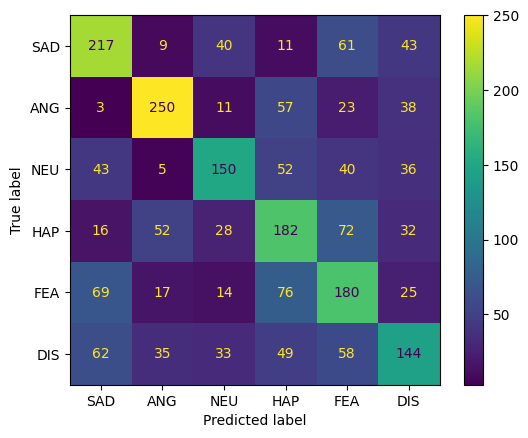

In [6]:
model.test(train_dataloader)
model.test(val_dataloader)
model.test(test_dataloader)
model.analyze(test_dataloader)